### Exploratory data analysis: NTS, Census commuting flows and Census travel data

In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import popgetter
from shapely import wkt

from acbm.config import load_and_setup_config
from acbm.utils import households_with_common_travel_days

cfg = pl.Config()
cfg = cfg.set_tbl_rows(80)

In [2]:
# Set dir as repo root
os.chdir("../")

# Example config
config = load_and_setup_config("config/2025-01-20_leeds_msoa_new_regions_03.toml")

# Load NTS
nts_hh: pl.DataFrame = pl.DataFrame(
    pd.read_csv(config.nts_households_filepath, sep="\t")
)
nts_ind: pl.DataFrame = pl.DataFrame(
    pd.read_csv(config.nts_individuals_filepath, sep="\t")
)
nts_trips: pl.DataFrame = pl.DataFrame(pd.read_csv(config.nts_trips_filepath, sep="\t"))

In [3]:
def get_psu(config):
    psu = pl.DataFrame(pd.read_csv(config.psu_filepath, sep="\t"))

    # PSUStatsReg_B01ID but does not have values for 2021 and 2022
    region_dict = {
        -10.0: "DEAD",
        -9.0: "DNA",
        -8.0: "NA",
        1.0: "Northern, Metropolitan",
        2.0: "Northern, Non-metropolitan",
        3.0: "Yorkshire / Humberside, Metropolitan",
        4.0: "Yorkshire / Humberside, Non-metropolitan",
        5.0: "East Midlands",
        6.0: "East Anglia",
        7.0: "South East (excluding London Boroughs)",
        8.0: "London Boroughs",
        9.0: "South West",
        10.0: "West Midlands, Metropolitan",
        11.0: "West Midlands, Non-metropolitan",
        12.0: "North West, Metropolitan",
        13.0: "North West, Non-metropolitan",
        14.0: "Wales",
        15.0: "Scotland",
    }

    # In the PSU table, create a column with the region names
    # psu["region_name"] = psu["PSUGOR_B02ID"].map(region_dict)
    return psu.with_columns(
        pl.col("PSUStatsReg_B01ID").replace(region_dict).alias("region_name")
    )

def transform_nts_trips(nts_trips: pl.DataFrame):
    nts_trips = nts_trips.rename(
        {  # rename data
            "JourSeq": "seq",
            "TripOrigGOR_B02ID": "ozone",
            "TripDestGOR_B02ID": "dzone",
            "TripPurpFrom_B01ID": "oact",
            "TripPurpTo_B01ID": "dact",
            "MainMode_B04ID": "mode",
            "TripStart": "tst",
            "TripEnd": "tet",
        }
    )
    mode_mapping = {
        1: "walk",
        2: "bike",
        3: "car",  #'Car/van driver'
        4: "car_passenger",  #'Car/van passenger'
        5: "motorcycle",  #'Motorcycle',
        6: "car",  #'Other private transport',
        7: "pt",  # Bus in London',
        8: "pt",  #'Other local bus',
        9: "pt",  #'Non-local bus',
        10: "pt",  #'London Underground',
        11: "pt",  #'Surface Rail',
        12: "taxi",  #'Taxi/minicab',
        13: "pt",  #'Other public transport',
        -10: "DEAD",
        -8: "NA",
    }

    purp_mapping = {
        1: "work",
        2: "work",  #'In course of work',
        3: "education",
        4: "shop",  #'Food shopping',
        5: "shop",  #'Non food shopping',
        6: "medical",  #'Personal business medical',
        7: "other",  #'Personal business eat/drink',
        8: "other",  #'Personal business other',
        9: "other",  #'Eat/drink with friends',
        10: "visit",  #'Visit friends',
        11: "other",  #'Other social',
        12: "other",  #'Entertain/ public activity',
        13: "other",  #'Sport: participate',
        14: "home",  #'Holiday: base',
        15: "other",  #'Day trip/just walk',
        16: "other",  #'Other non-escort',
        17: "escort",  #'Escort home',
        18: "escort",  #'Escort work',
        19: "escort",  #'Escort in course of work',
        20: "escort",  #'Escort education',
        21: "escort",  #'Escort shopping/personal business',
        22: "escort",  #'Other escort',
        23: "home",  #'Home',
        -10: "DEAD",
        -8: "NA",
    }
    return  nts_trips.with_columns(
        [
            pl.col("mode").replace(mode_mapping),
            pl.col("oact").replace(purp_mapping),
            pl.col("dact").replace(purp_mapping),
        ]
    )

In [4]:
# Get PSU
psu = get_psu(config)

# Transform NTS trips
nts_trips = transform_nts_trips(nts_trips)

In [5]:
# Explore work-related variables in NTS
workplace_var = "WkPlace_B01ID"
print(nts_ind.get_column(workplace_var).value_counts().sort("count"))

# TODO: explore matching with SPC pwkstat here

shape: (7, 2)
┌───────────────┬────────┐
│ WkPlace_B01ID ┆ count  │
│ ---           ┆ ---    │
│ i64           ┆ u32    │
╞═══════════════╪════════╡
│ -8            ┆ 562    │
│ 4             ┆ 8956   │
│ -10           ┆ 9642   │
│ 2             ┆ 11229  │
│ 3             ┆ 26699  │
│ 1             ┆ 125776 │
│ -9            ┆ 201353 │
└───────────────┴────────┘


In [6]:
# Addtionally can call this function to susbet the dataframes
def get_nts_subset(nts_hh, nts_ind, nts_trips):
    # Get HIDs with common travel days
    hids = households_with_common_travel_days(
        nts_trips.to_pandas(), config.parameters.nts_days_of_week
    )
    # Subset individuals and households given filtering of trips
    nts_trips = nts_trips.filter(
        pl.col("HouseholdID").is_in(hids)
        & pl.col("TravDay").is_in(config.parameters.nts_days_of_week)
        & pl.col("SurveyYear").is_in(config.parameters.nts_years)
    )
    nts_individuals = nts_ind.filter(pl.col("HouseholdID").is_in(hids))
    nts_hh = nts_hh.filter(pl.col("HouseholdID").is_in(hids))
    return nts_hh, nts_individuals, nts_trips

#### How does the distribution of travel times vary at the region level?

In [7]:

# get times grouped by region
col = "TripTotalTime"
# col = "TripDisIncSW"

mode = "car"
# mode = "pt"

by_region = (
    nts_trips.join(psu.select(["PSUID", "region_name"]), on="PSUID")
    .filter(pl.col("mode").eq(mode) & pl.col("dact").eq("work"))
    .group_by("region_name")
    .agg(
        [
            pl.col(col).quantile(0.25).alias("25th"),
            pl.col(col).quantile(0.5).alias("50th"),
            pl.col(col).quantile(0.75).alias("75th"),
            pl.col(col).mean().alias("mean"),
            pl.col(col).std().alias("std"),
        ]
    )
).sort("region_name")

by_region

region_name,25th,50th,75th,mean,std
str,f64,f64,f64,f64,f64
"""East Anglia""",10.0,20.0,30.0,26.00974,27.981864
"""East Midlands""",10.0,20.0,30.0,27.128805,30.180729
"""London Boroughs""",15.0,25.0,40.0,31.585612,27.175082
"""North West, Metropolitan""",14.0,20.0,30.0,27.037915,26.897918
"""North West, Non-metropolitan""",10.0,20.0,30.0,25.743562,27.560415
"""Northern, Metropolitan""",12.0,20.0,30.0,24.352651,28.566353
"""Northern, Non-metropolitan""",10.0,20.0,30.0,24.367163,26.913915
"""Scotland""",10.0,20.0,30.0,25.991696,33.810627
"""South East (excluding London B…",10.0,20.0,35.0,28.130086,28.709541


#### How does the proportion travelling to work change over time in NTS?

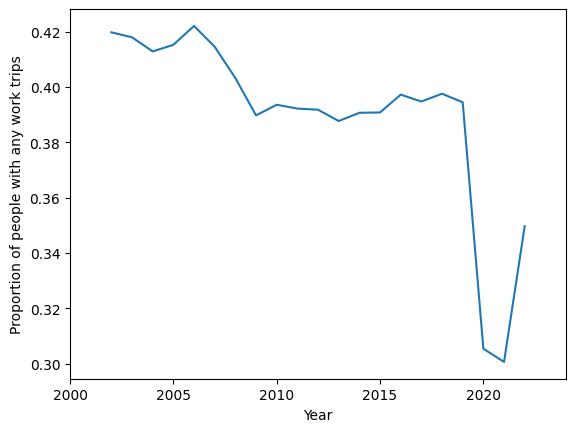

In [8]:
df = (
    nts_trips.group_by(["SurveyYear", "IndividualID"])
    .agg((pl.lit("work").is_in(pl.col("dact")) * 1).alias("any_work_activity"))
    .group_by("SurveyYear")
    .mean()
    .sort("SurveyYear")
    .select(["SurveyYear", "any_work_activity"])
)

plt.plot(df.select("SurveyYear"), df.select("any_work_activity"))
plt.gca().set(
    xlim=(2000, 2024), ylabel="Proportion of people with any work trips", xlabel="Year"
)
plt.show()


### What is the spatial distribution of distance travelled to work

Here we explore the spatial distribution by distance travelled to work in the study area.

In [9]:
# Explore distance to work in study region
def get_census_data(config, include_geometry=True, use_cache=True):
    filepath = config.external_path / "TS058-2021-msoa-leeds.csv"
    if os.path.isfile(filepath) and use_cache:
        return pd.read_csv(filepath)

    # Search and download data with search params
    search_params = {
        # Short metric IDs for reference
        # "metric_id": [
        #     {"id": "2619a2b91e"}, {"id": "512663ccc3"}, {"id": "dc435eb8d0"}, {"id": "d92aca6569"},
        #     {"id": "cfdb70149d"}, {"id": "af7bebda58"}, {"id": "b660dd5386"}, {"id": "efa45af2da"},
        #     {"id": "71154fc462"}, {"id": "55426cb07f"},
        # ],
        "metric_id": [],
        "text": [
            {
                "text": "Distance travelled to work:",
                "config": {"match_type": "Regex", "case_sensitivity": "Insensitive"},
                "context": ["HumanReadableName"],
            }
        ],
        "geometry_level": {
            "value": "msoa",
            "config": {"match_type": "Exact", "case_sensitivity": "Insensitive"},
        },
        "year_range": [{"Between": [2021, 2021]}],
        "country": {
            "value": "England and Wales",
            "config": {"match_type": "Regex", "case_sensitivity": "Insensitive"},
        },
        # Currently popgetter python bindings require specification in CRS of data (27700 for England and Wales)
        # "region_spec": [{"BoundingBox": [390955, 403436, 474332, 460372]}],
        # "region_spec": [{"include_geometry": include_geometry}]
    }
    df = popgetter.download(search_params).to_pandas()
    df.to_csv(filepath, index=None)
    return df

def get_geo_df_and_study_area(config):
    # Read TS058 census table at MSOA level
    df = get_census_data(config)
    df = gpd.GeoDataFrame(df)
    df["geometry"] = df["geometry"].map(lambda geo: wkt.loads(geo))
    return df.set_geometry("geometry").set_crs(27700), config.get_study_area_boundaries()


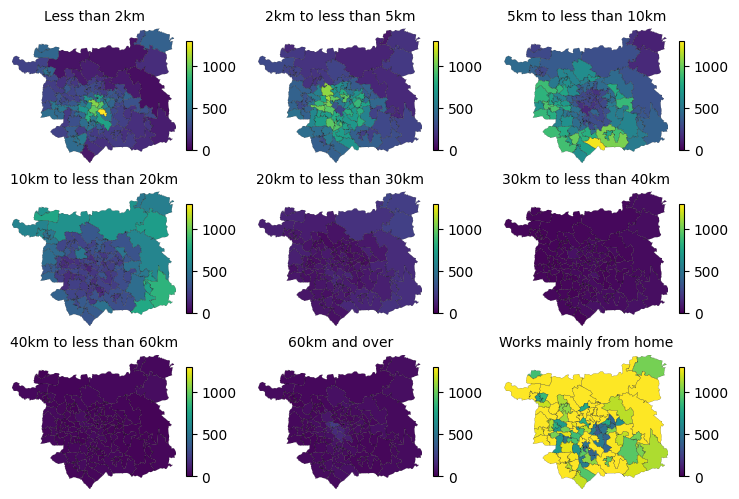

In [10]:
# Get census data and study area
gdf, study_area = get_geo_df_and_study_area(config)

# Subset to study area
gdf = gdf[gdf["GEO_ID"].isin(study_area["MSOA21CD"])]

# Plot
cols = gdf.columns[3:-1]
nrows, ncols = 3, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(9, 6))
for idx, column in enumerate(cols):
    row = idx // ncols
    col = idx % ncols
    ax = axs[row, col]
    legend_kwds = {"shrink": 0.8}
    gdf.plot(
        ax=ax,
        column=column,
        legend=True,
        cmap="viridis",
        legend_kwds=legend_kwds,
        vmin=0,
        vmax=gdf[cols].max().values[0],
    )
    ax.axis("off")
    minx, miny, maxx, maxy = gdf.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    study_area.plot(facecolor="none", edgecolor="black", lw=0.1, ax=ax)
    ax.set_title(column.split("Distance travelled to work: ")[1], size="medium")
plt.show()

#### What propotion of those employed mainly working from home (2021 census)

In [11]:
# Get census data for all MSOAs
df: pl.DataFrame = popgetter.download_data_request(
    {
        "region": [],
        "metrics": [
            {"MetricText": "Distance travelled"},
        ],
        "years": ["2021"],
        "geometry": {"geometry_level": "msoa", "include_geoms": False},
        "region_spec": [],
        # TODO: this appears to have no effect
        # "region_spec": [{"BoundingBox": [390955, 403436, 474332, 460372]}],
    }
)


In [12]:
# Transform and plot histogram
df.select(
    pl.col("*")
    .exclude(
        "Distance travelled to work: Total: All usual residents aged 16 years and over in employment the week before the census"
    )
    .exclude("Distance travelled to work: Works mainly from home")
    .exclude(
        "Distance travelled to work: Works mainly at an offshore installation, in no fixed place, or outside the UK"
    )
).melt(id_vars="GEO_ID").group_by("GEO_ID").agg(pl.col("value").sum().alias("Travel to work")).join(
    df.select([
        pl.col("GEO_ID"),
        pl.col("Distance travelled to work: Works mainly from home").alias("WFH"),
        pl.col('Distance travelled to work: Total: All usual residents aged 16 years and over in employment the week before the census').alias("Total employed")
    ]),
    on="GEO_ID"
).select([
    (pl.col("WFH")/pl.col("Total employed")).alias("Proportion WFH")
]).plot(kind="hist", xlim=(0, 1), title="Proportion employed mainly working from home by MSOA")


:Histogram   [Proportion WFH]   (Count)